# Imports

In [1]:
import glob
import os
import random

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
from helpers import (
    _augment_with_reverse_mutation,
    _populate_dfs_with_nlls_and_nlfs,
    _populate_dfs_with_resenvs,
    _train_loop,
    _train_val_split,
    _get_ddg_training_dataloaders,
    _get_ddg_validation_dataloaders,
    _train_downstream_and_evaluate,
)
from visualization import scatter_pred_vs_true, plot_validation_performance

%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# Run shell script that takes a .txt file with PDBIDs as input.
!./get_and_parse_pdbs_for_cavity_model.sh data/pdbids_250.txt

Successfully downloaded 4X2U.pdb to data/pdbs/raw/4X2U.pdb. 1/250.
Successfully downloaded 2X96.pdb to data/pdbs/raw/2X96.pdb. 2/250.
Successfully downloaded 4MXD.pdb to data/pdbs/raw/4MXD.pdb. 3/250.
Successfully downloaded 3E9L.pdb to data/pdbs/raw/3E9L.pdb. 4/250.
Successfully downloaded 1UWC.pdb to data/pdbs/raw/1UWC.pdb. 5/250.
Successfully downloaded 4BGU.pdb to data/pdbs/raw/4BGU.pdb. 6/250.
Successfully downloaded 2YSW.pdb to data/pdbs/raw/2YSW.pdb. 7/250.
Successfully downloaded 4OW4.pdb to data/pdbs/raw/4OW4.pdb. 8/250.
Successfully downloaded 2V5E.pdb to data/pdbs/raw/2V5E.pdb. 9/250.
Successfully downloaded 1IXH.pdb to data/pdbs/raw/1IXH.pdb. 10/250.
Successfully downloaded 3ZR9.pdb to data/pdbs/raw/3ZR9.pdb. 11/250.
Successfully downloaded 4O7Q.pdb to data/pdbs/raw/4O7Q.pdb. 12/250.
Successfully downloaded 3OBL.pdb to data/pdbs/raw/3OBL.pdb. 13/250.
Successfully downloaded 2YVP.pdb to data/pdbs/raw/2YVP.pdb. 14/250.
Successfully downloaded 1UNK.pdb to data/pdbs/raw/1UNK.pd

Successfully downloaded 1BU2.pdb to data/pdbs/raw/1BU2.pdb. 122/250.
Successfully downloaded 5MND.pdb to data/pdbs/raw/5MND.pdb. 123/250.
Successfully downloaded 1EI9.pdb to data/pdbs/raw/1EI9.pdb. 124/250.
Successfully downloaded 1KUU.pdb to data/pdbs/raw/1KUU.pdb. 125/250.
Successfully downloaded 5AYE.pdb to data/pdbs/raw/5AYE.pdb. 126/250.
Successfully downloaded 1L2P.pdb to data/pdbs/raw/1L2P.pdb. 127/250.
Successfully downloaded 4O7K.pdb to data/pdbs/raw/4O7K.pdb. 128/250.
Successfully downloaded 1AGJ.pdb to data/pdbs/raw/1AGJ.pdb. 129/250.
Successfully downloaded 1ZZG.pdb to data/pdbs/raw/1ZZG.pdb. 130/250.
Successfully downloaded 4UEJ.pdb to data/pdbs/raw/4UEJ.pdb. 131/250.
Successfully downloaded 5HI8.pdb to data/pdbs/raw/5HI8.pdb. 132/250.
Successfully downloaded 1HG0.pdb to data/pdbs/raw/1HG0.pdb. 133/250.
Successfully downloaded 1EX7.pdb to data/pdbs/raw/1EX7.pdb. 134/250.
Successfully downloaded 1V7C.pdb to data/pdbs/raw/1V7C.pdb. 135/250.
Successfully downloaded 1QJ8.pdb t

Successfully downloaded 4WP4.pdb to data/pdbs/raw/4WP4.pdb. 241/250.
Successfully downloaded 2W5Q.pdb to data/pdbs/raw/2W5Q.pdb. 242/250.
Successfully downloaded 4IG2.pdb to data/pdbs/raw/4IG2.pdb. 243/250.
Successfully downloaded 5ECX.pdb to data/pdbs/raw/5ECX.pdb. 244/250.
Successfully downloaded 2V66.pdb to data/pdbs/raw/2V66.pdb. 245/250.
Successfully downloaded 1A44.pdb to data/pdbs/raw/1A44.pdb. 246/250.
Successfully downloaded 1DQ3.pdb to data/pdbs/raw/1DQ3.pdb. 247/250.
Successfully downloaded 1YTS.pdb to data/pdbs/raw/1YTS.pdb. 248/250.
Successfully downloaded 1NG6.pdb to data/pdbs/raw/1NG6.pdb. 249/250.
Successfully downloaded 2CZQ.pdb to data/pdbs/raw/2CZQ.pdb. 250/250.
Successfully cleaned data/pdbs/raw/1A44.pdb and added it to data/pdbs/cleaned/. 1/250.
Successfully cleaned data/pdbs/raw/1A6M.pdb and added it to data/pdbs/cleaned/. 2/250.
Successfully cleaned data/pdbs/raw/1AGJ.pdb and added it to data/pdbs/cleaned/. 3/250.
Successfully cleaned data/pdbs/raw/1ALY.pdb and a

Successfully cleaned data/pdbs/raw/1ZH1.pdb and added it to data/pdbs/cleaned/. 87/250.
Successfully cleaned data/pdbs/raw/1ZZG.pdb and added it to data/pdbs/cleaned/. 88/250.
Successfully cleaned data/pdbs/raw/2ABK.pdb and added it to data/pdbs/cleaned/. 89/250.
Successfully cleaned data/pdbs/raw/2ACY.pdb and added it to data/pdbs/cleaned/. 90/250.
Successfully cleaned data/pdbs/raw/2BK8.pdb and added it to data/pdbs/cleaned/. 91/250.
Successfully cleaned data/pdbs/raw/2BNU.pdb and added it to data/pdbs/cleaned/. 92/250.
Successfully cleaned data/pdbs/raw/2CB5.pdb and added it to data/pdbs/cleaned/. 93/250.
Successfully cleaned data/pdbs/raw/2CE8.pdb and added it to data/pdbs/cleaned/. 94/250.
Successfully cleaned data/pdbs/raw/2CN4.pdb and added it to data/pdbs/cleaned/. 95/250.
Successfully cleaned data/pdbs/raw/2CZQ.pdb and added it to data/pdbs/cleaned/. 96/250.
Successfully cleaned data/pdbs/raw/2D3Y.pdb and added it to data/pdbs/cleaned/. 97/250.
Successfully cleaned data/pdbs/r

Successfully cleaned data/pdbs/raw/3WMI.pdb and added it to data/pdbs/cleaned/. 180/250.
Successfully cleaned data/pdbs/raw/3X2Z.pdb and added it to data/pdbs/cleaned/. 181/250.
Successfully cleaned data/pdbs/raw/3ZR9.pdb and added it to data/pdbs/cleaned/. 182/250.
Successfully cleaned data/pdbs/raw/4AS2.pdb and added it to data/pdbs/cleaned/. 183/250.
Successfully cleaned data/pdbs/raw/4BGU.pdb and added it to data/pdbs/cleaned/. 184/250.
Successfully cleaned data/pdbs/raw/4BGV.pdb and added it to data/pdbs/cleaned/. 185/250.
Successfully cleaned data/pdbs/raw/4BHB.pdb and added it to data/pdbs/cleaned/. 186/250.
Successfully cleaned data/pdbs/raw/4DH4.pdb and added it to data/pdbs/cleaned/. 187/250.
Successfully cleaned data/pdbs/raw/4DM1.pdb and added it to data/pdbs/cleaned/. 188/250.
Successfully cleaned data/pdbs/raw/4DPB.pdb and added it to data/pdbs/cleaned/. 189/250.
Successfully cleaned data/pdbs/raw/4DWQ.pdb and added it to data/pdbs/cleaned/. 190/250.
Successfully cleaned 

Successfully parsed 1DXG_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 21/250.
Successfully parsed 1EBF_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 22/250.
Successfully parsed 1EI9_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 23/250.
Successfully parsed 1EKM_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 24/250.
Successfully parsed 1EX7_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 25/250.
Successfully parsed 1F47_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 26/250.
Successfully parsed 1FEZ_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 27/250.
Successfully parsed 1GNT_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 28/250.
Successfully parsed 1GVR_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 29/250.
Successfully parsed 1GYX_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 30/250.
Successfully parsed 1H16_clean.pdb and moved parse

Successfully parsed 2IFV_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 108/250.
Successfully parsed 2IVG_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 109/250.
Successfully parsed 2J9V_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 110/250.
Successfully parsed 2JA4_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 111/250.
Successfully parsed 2JHF_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 112/250.
Successfully parsed 2JL1_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 113/250.
Successfully parsed 2NXV_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 114/250.
Successfully parsed 2OF3_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 115/250.
Successfully parsed 2OKT_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 116/250.
Successfully parsed 2OR2_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 117/250.
Successfully parsed 2OYA_clean.pdb and m

Successfully parsed 4FD2_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 194/250.
Successfully parsed 4FD9_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 195/250.
Successfully parsed 4FIV_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 196/250.
Successfully parsed 4G94_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 197/250.
Successfully parsed 4ICQ_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 198/250.
Successfully parsed 4IG2_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 199/250.
Successfully parsed 4KNU_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 200/250.
Successfully parsed 4LBS_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 201/250.
Successfully parsed 4MXD_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 202/250.
Successfully parsed 4NNK_clean.pdb and moved parsed file to data/pdbs/parsed. Finished 203/250.
Successfully parsed 4O7K_clean.pdb and m

<IPython.core.display.Javascript object>

Global variables

In [3]:
# Main parameters
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
SHUFFLE_PDBS = True
LEARNING_RATE = 3e-4
EPOCHS = 10
PATIENCE_CUTOFF = 1
EPS = 1e-9

# Parameters specific to downstream model
BATCH_SIZE_DDG = 40
SHUFFLE_DDG = True
LEARNING_RATE_DDG = 1e-3
EPOCHS_DDG = 100

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [4]:
parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
if SHUFFLE_PDBS:
    random.shuffle(parsed_pdb_filenames)
dataloader_train, dataset_train, dataloader_val, dataset_val = _train_val_split(
    parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
)

Training data set includes 200 pdbs with 91768 environments.
Validation data set includes 50 pdbs with 19232 environments.


<IPython.core.display.Javascript object>

Train the cavity model

In [5]:
# Define model
cavity_model_net = CavityModel(DEVICE).to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

# Create directory for model files
models_dirpath = "cavity_models/"
if not os.path.exists(models_dirpath):
    os.mkdir(models_dirpath)

# Train loop
best_model_path = _train_loop(
    dataloader_train,
    dataloader_val,
    cavity_model_net,
    loss_function,
    optimizer,
    EPOCHS,
    PATIENCE_CUTOFF,
)

Epoch  0. Train loss: 1.893. Train Acc: 0.43. Val loss: 1.842. Val Acc 0.43
Epoch  1. Train loss: 1.303. Train Acc: 0.61. Val loss: 1.850. Val Acc 0.43
Epoch  2. Train loss: 0.984. Train Acc: 0.71. Val loss: 1.949. Val Acc 0.43
Early stopping activated.
Best epoch idx: 0 with validation loss: 1.842 and model_path: cavity_models/model_epoch_00.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Parse PDBs for DMS, Guerois and Protein G data sets

In [6]:
# Parse PDBs for which we have ddG data
!./get_and_parse_pdbs_for_dowstream_task.sh

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [7]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [8]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [9]:
_populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    1 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [10]:
# Load best performing cavity model from previos training
cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(torch.load(best_model_path))
cavity_model_infer_net.eval()

_populate_dfs_with_nlls_and_nlfs(
    ddg_data_dict, cavity_model_infer_net, DEVICE, BATCH_SIZE, EPS, display_n_rows=2
)

dms


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
120,1D5R,A,R14A,-0.087552,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,0,"[5.208927, 4.623146, 4.039332, 5.058001, 4.835...",1.607062,5.208927,3.035567,2.483982,4.153450
121,1D5R,A,R14D,-0.142873,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,2,"[5.208927, 4.623146, 4.039332, 5.058001, 4.835...",1.607062,4.039332,3.035567,2.824680,2.643158


protein_g


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,1PGA,A,M1A,-0.1407,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,0,"[2.3750665, 3.602623, 3.3328314, 3.0284564, 4....",2.917011,2.375067,3.785957,2.483982,0.760030
1,1PGA,A,M1D,-0.3795,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,2,"[2.3750665, 3.602623, 3.3328314, 3.0284564, 4....",2.917011,3.332831,3.785957,2.824680,1.377098


guerois


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,171L,A,A45E,0.01,<ResidueEnvironment with 189 atoms. pdb_id: 17...,0,3,"[0.83523524, 4.4478774, 2.830563, 2.008929, 2....",0.835235,2.008929,2.483982,2.712832,0.944844
1,1A2P,A,Y103F,0.00,<ResidueEnvironment with 211 atoms. pdb_id: 1A...,19,4,"[4.11355, 4.059737, 4.051206, 3.9646528, 1.218...",1.690269,1.218703,3.311580,3.207937,-0.367925


symmetric_direct


,pdbid,chainid,variant,ddg,merge_column,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,1AMQ,A,C191Y,2.3,index_1,<ResidueEnvironment with 278 atoms. pdb_id: 1A...,1,19,"[0.6998306, 3.7237372, 3.3151283, 5.2741637, 3...",3.723737,3.835413,4.33514,3.311580,1.135236
1,1AMQ,A,C191F,1.6,index_2,<ResidueEnvironment with 278 atoms. pdb_id: 1A...,1,4,"[0.6998306, 3.7237372, 3.3151283, 5.2741637, 3...",3.723737,3.773518,4.33514,3.207937,1.176983


symmetric_inverse


,pdbid,chainid,variant,ddg,merge_column,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
1,1QIS,A,F191C,-1.6,index_2,<ResidueEnvironment with 275 atoms. pdb_id: 1Q...,4,1,"[2.4564798, 3.7821703, 4.3555284, 5.4382453, 0...",0.819643,3.782170,3.207937,4.33514,1.835325
2,1QIT,A,W191C,-3.9,index_3,<ResidueEnvironment with 273 atoms. pdb_id: 1Q...,18,1,"[1.8615029, 4.2089725, 4.0728025, 5.3598213, 1...",2.500774,4.208972,4.250501,4.33514,1.623560


<IPython.core.display.Javascript object>

### Results without downstream model

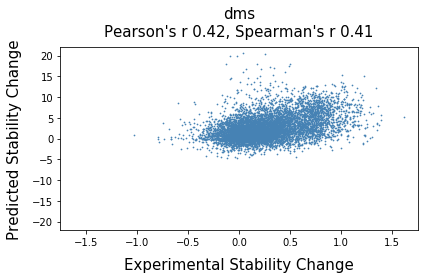

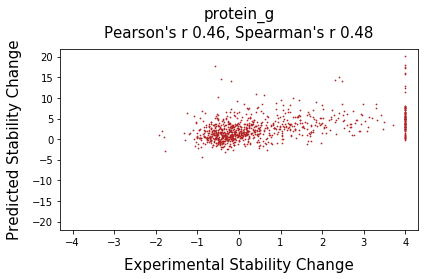

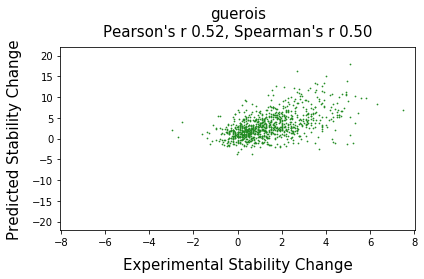

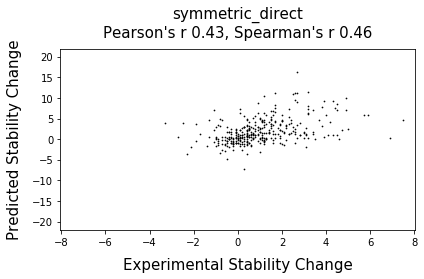

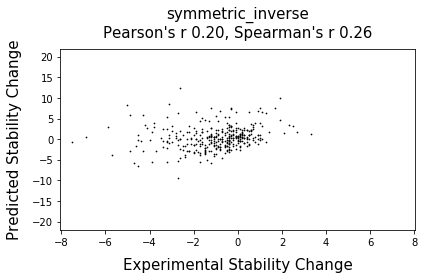

<IPython.core.display.Javascript object>

In [11]:
colors = ["steelblue", "firebrick", "forestgreen", "black", "black"]
for color, data_key in zip(colors, ddg_data_dict.keys()):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=color,
        title=data_key,
    )

Merge direct and inverse dfs

In [12]:
# Rename columns so they specify if it is the direct or inverse direction
symmetric_direct_df = ddg_data_dict["symmetric_direct"]
symmetric_direct_df.columns = [
    name + "_dir" if "_dir" not in name else name
    for name in symmetric_direct_df.columns
]
symmetric_inverse_df = ddg_data_dict["symmetric_inverse"]
symmetric_inverse_df.columns = [
    name + "_inv" if "_inv" not in name else name
    for name in symmetric_inverse_df.columns
]

# Inner merge both dataframes
ddg_data_dict["symmetric_both"] = pd.merge(
    symmetric_direct_df,
    symmetric_inverse_df,
    how="inner",
    left_on="merge_column_dir",
    right_on="merge_column_inv",
)

<IPython.core.display.Javascript object>

Make prediction based on both structures

In [13]:
symmetric_both_df = ddg_data_dict["symmetric_both"]
symmetric_both_df["ddg_pred_no_ds_both_dir"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_dir"] - row["ddg_pred_no_ds_inv"]), axis=1
)
symmetric_both_df["ddg_pred_no_ds_both_inv"] = symmetric_both_df.apply(
    lambda row: 0.5 * (row["ddg_pred_no_ds_inv"] - row["ddg_pred_no_ds_dir"]), axis=1
)

<IPython.core.display.Javascript object>

Plot prediction using both structures

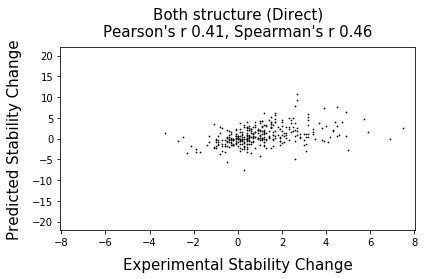

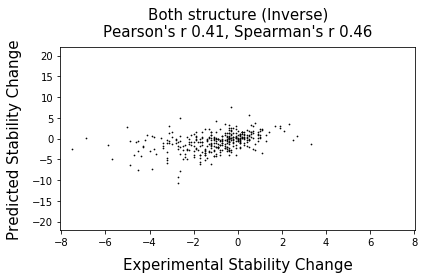

<IPython.core.display.Javascript object>

In [14]:
# Plot prediction for ddg direct using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_dir"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_dir"],
    color="black",
    title="Both structure (Direct)",
)

# Plot prediction for ddg inverse using both structures
fig, ax = scatter_pred_vs_true(
    ddg_data_dict["symmetric_both"]["ddg_inv"],
    ddg_data_dict["symmetric_both"]["ddg_pred_no_ds_both_inv"],
    color="black",
    title="Both structure (Inverse)",
)

# Downstream model

Before training we "augment" our dataset simply by adding the reverse mutation with -ddG value

In [15]:
ddg_data_dict_augmented = _augment_with_reverse_mutation(ddg_data_dict)

<IPython.core.display.Javascript object>

Define training dataloader (augmented data) and eval dataloaders (original data)

In [16]:
ddg_dataloaders_train_dict = _get_ddg_training_dataloaders(
    ddg_data_dict_augmented, BATCH_SIZE_DDG, SHUFFLE_DDG
)
ddg_dataloaders_val_dict = _get_ddg_validation_dataloaders(ddg_data_dict)

<IPython.core.display.Javascript object>

Train and report on the data that is not used during training

In [17]:
pearsons_r_results_dict = _train_downstream_and_evaluate(
    ddg_dataloaders_train_dict,
    ddg_dataloaders_val_dict,
    DEVICE,
    LEARNING_RATE_DDG,
    EPOCHS_DDG,
)

/home/chz526/software/miniconda3/envs/cavity-model/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<IPython.core.display.Javascript object>

Plot results

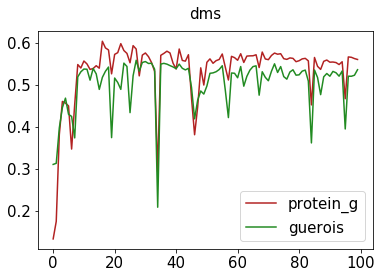

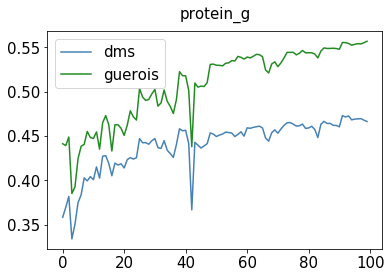

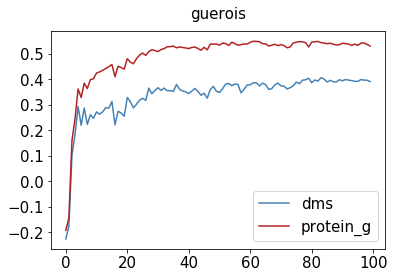

<IPython.core.display.Javascript object>

In [18]:
for key in pearsons_r_results_dict.keys():
    _ = plot_validation_performance(key, pearsons_r_results_dict[key])